# Homework 6: Fast fourier transform 
Name: Aurelia Brook

## 1. LIGO

Use Fourier techniques to find the merging black hole signal *GW150914*. Write a Python program to read in the LIGO data, do some simple cleaning, and find the signal.

LIGO has two independent observatories, one in Livingston, LO and
the other in Hanford, WA. Both detectors must see a signal within
10ms of each other for it to count! A window of data (32 seconds)
around the time of the event is available for download here: 

Hanford data:
https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5

Livingston data:
https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5

These are HDF5 files. These files are much smaller and quicker to read/write than plain text files. The **h5py** library (included in Anaconda and available through pip) interacts with these files. See the documentation: https://docs.h5py.org/en/stable/

A function to do so is:

In [37]:
import h5py
import matplotlib.pyplot as plt
import numpy as np


def loadLIGOdata(filename):
    f = h5py.File(filename, "r")
    strain = f['strain/Strain'][...]
    t0 = f['strain/Strain'].attrs['Xstart'] 
    dt = f['strain/Strain'].attrs['Xspacing'] 
    print(dt)
    t = t0 + dt * np.arange(strain.shape[0]) 
    f.close()
    return t, strain

This returns the time (in seconds) and the strain (which has no units). The measurements in this data set are evenly sampled at 4096Hz.

The strain $h(t)$ is what is measured by LIGO. You can think of it as the fractional change in the length of the 4km interferometer arms:
$\Delta L/L$. Plot the strain as a function of time for both detectors. Gravitational waves from astrophysical sources produce a maximum strain on Earth of about $10^{−21}$. Can you see a gravitational wave in the data?

0.000244140625


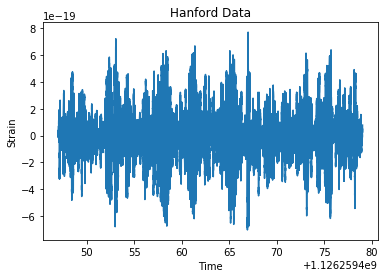

0.000244140625


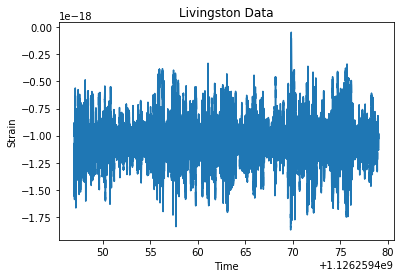

In [38]:
hdata = loadLIGOdata("Hanforddata.hdf5")
plt.plot(hdata[0], hdata[1])
plt.xlabel("Time")
plt.ylabel("Strain")
plt.title("Hanford Data")
plt.show()

ldata = loadLIGOdata("Livingstondata.hdf5")
plt.plot(ldata[0], ldata[1])
plt.xlabel("Time")
plt.ylabel("Strain")
plt.title("Livingston Data")
plt.show()

You probably didn't see much. Most of the strain is “noise” coming from various physical effects in the detector. To find how the noise affects the data, plot the power spectral density $P = |h(f)|^2$ of the data for each detector using your FFT. 

[ 0.       0.03125  0.0625  ... -0.09375 -0.0625  -0.03125]


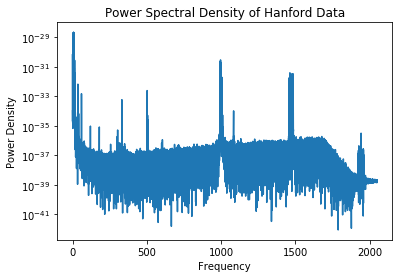

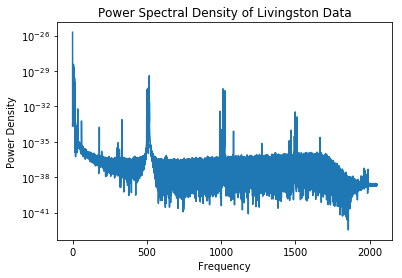

In [39]:
fft_hdata=np.fft.fft(hdata[1])
fft_ldata=np.fft.fft(ldata[1])

f = np.fft.fftfreq(hdata[1].size, 1/4096)
print(f)

plt.plot(f[:hdata[1].size//2], [np.abs(x) ** 2 for x in fft_hdata][:hdata[1].size//2])
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.yscale('log')
plt.title("Power Spectral Density of Hanford Data")
plt.show()

plt.plot(f[:ldata[1].size//2], [np.abs(x) ** 2 for x in fft_ldata][:ldata[1].size//2])
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.yscale('log')
plt.title("Power Spectral Density of Livingston Data")
plt.show()

The power spectral density shows a lot of power for $f < 30Hz$ and many spectral lines. These lines correspond to resonances in the LIGO machinery (the cables suspending the mirrors, the 60Hz electrical frequency, etc). These are clearly noise! Filtering out particular modes in Fourier space is not difficult, simply multiply the DFT of your data $h(f)$ by a transfer function $H(f)$, then perform the inverse transform to see the filtered data. Here are two very simple filters:
\begin{equation}
H_{step}(f)=\frac{1}{1+(f/f_0)^{2n}},
\end{equation}
and 
\begin{equation}
H_{gauss}(f)=1-\exp{\left[-\frac{(f-f_0)^2}{2 \sigma^2}\right]}.
\end{equation}
In the above, $f0$ is the location of the filter and $n$ or $\sigma$ control the width. What does each filter do?

##### Answer: #####
$H_{step}(f)$ acts as a box filter centered at 0. The size of the box is dependent on $f_0$, so values inside the box are close to 1, and values outside the box are close to 0. This dampens things outside of the range while keeping ~true values within the range.


$H_{gauss}(f)$ is centered at $f_0$, and $\sigma$ controls the range. Inside the range, values are dampened, wheres values outside of the range are kept close to their original value. When using both filters centered at the same value, most values are dampened outside of a few values that would then easily stand out.

LIGO is most sensitive between 35Hz and 350Hz. Use $H_{step}$ with $n \sim 8$ to filter out the modes outside this band. Plot the resulting waveform and the power spectral density

In [40]:
def filterStep(f, f_0, n):
    return 1/(1+(f/f_0)**(2*n))

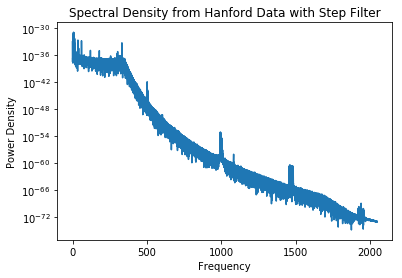

/Users/aureliabrook/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


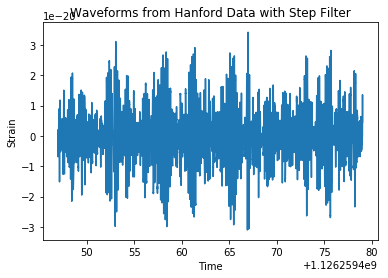

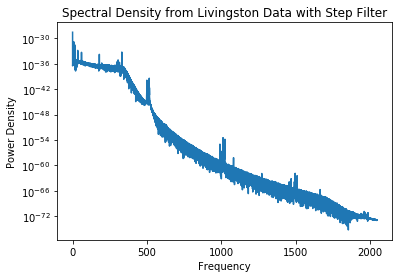

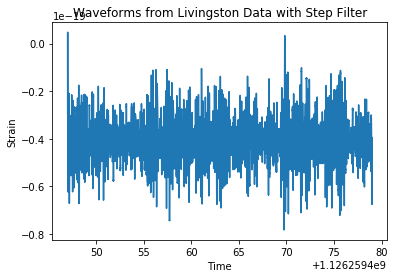

In [41]:
filter_hdata = fft_hdata * filterStep((350+35)/2 - f, (350 - 35)/2, 8)
plt.plot(f[:hdata[1].size//2], [np.abs(x) ** 2 for x in filter_hdata][:hdata[1].size//2])
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.yscale('log')
plt.title("Spectral Density from Hanford Data with Step Filter")
plt.show()

plt.plot(hdata[0], np.fft.ifft(filter_hdata))
plt.xlabel("Time")
plt.ylabel("Strain")
plt.title("Waveforms from Hanford Data with Step Filter")
plt.show()

filter_ldata = fft_ldata * filterStep((350+35)/2 - f, (350 - 35)/2, 8)
plt.plot(f[:ldata[1].size//2], [np.abs(x) ** 2 for x in filter_ldata][:ldata[1].size//2])
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.yscale('log')
plt.title("Spectral Density from Livingston Data with Step Filter")
plt.show()

plt.plot(ldata[0], np.fft.ifft(filter_ldata))
plt.xlabel("Time")
plt.ylabel("Strain")
plt.title("Waveforms from Livingston Data with Step Filter")
plt.show()

See a signal yet? Use the $H_{gauss}$ filter to remove spectral lines from the data as well. Plot the resulting waveform and power spectrum.

In [42]:
def filterGauss(f, f_0, sigma):
    return 1 - np.exp(-(f-f_0)**2/(2*sigma ** 2))

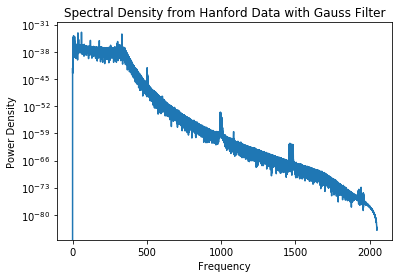

/Users/aureliabrook/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


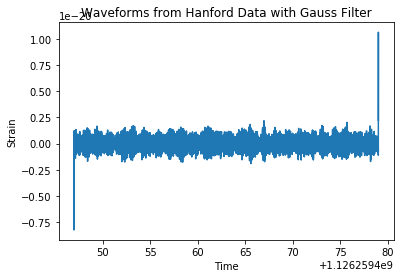

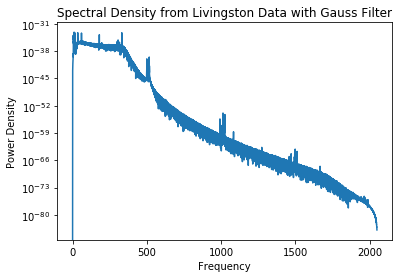

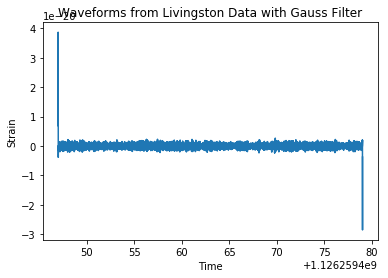

In [43]:
filter_hdata = filter_hdata * filterGauss(f, 0, 25) * filterGauss(f, 2050, 750)
plt.plot(f[:hdata[1].size//2], [np.abs(x) ** 2 for x in filter_hdata][:hdata[1].size//2])
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.yscale('log')
plt.title("Spectral Density from Hanford Data with Gauss Filter")
plt.show()

plt.plot(hdata[0], np.fft.ifft(filter_hdata))
plt.xlabel("Time")
plt.ylabel("Strain")
plt.title("Waveforms from Hanford Data with Gauss Filter")
plt.show()

filter_ldata = filter_ldata * filterGauss(f, 0, 25) * filterGauss(f, 2050, 750)
plt.plot(f[:ldata[1].size//2], [np.abs(x) ** 2 for x in filter_ldata][:ldata[1].size//2])
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.yscale('log')
plt.title("Spectral Density from Livingston Data with Gauss Filter")
plt.show()

plt.plot(ldata[0], np.fft.ifft(filter_ldata))
plt.xlabel("Time")
plt.ylabel("Strain")
plt.title("Waveforms from Livingston Data with Gauss Filter")
plt.show()

This dataset contains the first ever detection of a binary black hole merger! What time does it occur at? Remember: a real signal appears in both data sets with a time delay of no more than 10ms. Compute the cross-correlation beweteen the signal at Handford and Livingston.


In [51]:
np.correlate(fft_hdata, fft_hdata)

array([8.17107229e-28+0.j])

It looks like there is a signal between the 65 and 70 marks.